## 第一部分：PyTorch深度学习基础知识


### 2.2深度学习在实现上的特殊性
- 样本量大，通常需要分批（bath）加载
- 逐层、模板化搭建网络（卷积层、全连接、LSTM等）
- 多样化的损失函数和优化器设计*
- GPU的使用
- 模块间配合

## 2.3PyTorch深度学习模块
- 世纪使用根据需要进行修改
- 深度学习：搭积木
  - 2.3.1基本配置
  - 2.3.2数据读入
  - 2.3.3模型构建
  - 2.3.4损失函数
  - 2.3.5优化器
  - 2.3.6优化与评估
- 边学边练，通过实战案例巩固
- 任务：FashionMNIST时装分类
- 数据简介：
  - 10类图片
  - 32*32px

### 2.
- 导入必要的packages
 - os ,numpy, pandas, torch, torch.nn,torch.optin, torch.utils.data
- 配置训练过程中的超参数
 - batch size,learning rate,max_epochs,num_workers
- 配置训练用的硬件设备
 - cpu ,GPU,
- 代码演示

In [1]:
#导包
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.optim as optimizer

#### 配置训练环境和超参数


In [2]:
# 配置GPU,这里有两种方式
## 一：os.environ
#os.environ['CUDA_VISIBLE_DEVICES']='0'#这里的0就是第一块显卡
# 二：使用“device”,后续对要使用GPU的变量.to(device)即可
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

## 配置其他超参数，batch size,learning rate,max_epochs,num_workers
batch_size=256#每次训练数据的量
num_workers=4#有多少个线程
lr=1e-4#learn rate 每次更新步长
epochs=20#总的epochs 训练多少轮


In [3]:
#torch.cuda.is_available()#我用的cpu版本，emm小的模型也是可以跑的，大家最好下载GPU版本

In [3]:
from torchvision import transforms
image_size=28
data_transform=transforms.Compose([
   # transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [4]:
#读取方式一
from torchvision import datasets
train_data = datasets.FashionMNIST(root= './',train=True,download=True,transform=data_transform)#train_data是训练集
test_data = datasets.FashionMNIST(root='./',train=False,download=True,transform=data_transform)#test_data是测试

In [ ]:
- PyTorch数据读入是通过Dataset+DataLoader的方式完成的，Dataset定义好数据的格式和数据变换形式，DataLoader用iterative的方式不断读入批次数据。

  我们可以定义自己的Dataset类来实现灵活的数据读取，定义的类需要继承PyTorch自身的Dataset类。主要包含三个函数：

  - __init__: 用于向类中传入外部参数，同时定义样本集

  - __getitem__: 用于逐个读取样本集合中的元素，可以进行一定的变换，并将返回训练/验证所需的数据

  - __len__: 用于返回数据集的样本数

   下面以cifar10数据集为例给出构建Dataset类的方式：

In [33]:
#读取方式二:读入csv格式的数据，自行构建Dataset类
#csv数据下载链接：https://www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):
    def __init__(self,df,transform=None):#初始化
        self.df=df
        self.transform=transform
        self.images=df.iloc[:,1:].values.astype(np.uint8)#提取对应子片段，unit8图片格式
        self.labels=df.iloc[:,0].values
    def __len__(self):#图片长度
        return len(self.images)
    def __getitem__(self,idx):#直接决定Dataset怎么构建
        image=self.images[idx].reshape(28,28,1)#idx便是第几行
        label=int(self.labels[idx])
        if self.transform is not None:
            image=self.transform(image)  
        else:
            image=torch.tensor(image/255.,dtype=torch.float)
        label=torch.tensor(label,dtype=torch.long)
        return image,label
train_df =pd.read_csv("./FashionMNIST/fashion-mnist_train.csv")#我也不知到为啥File b'./FashionMNIST/fashion-mnist_train.csv' does not exist
test_df =pd.read_csv('./FashionMNIST/fashion-mnist_test.csv')
train_data=FMDataset(train_df,data_transform)
test_data=FMDataset(test_df,data_transform)

FileNotFoundError: File b'./FashionMNIST/fashion-mnist_train.csv' does not exist

In [ ]:
train.df

In [8]:
#在构建训练和测试集完成后，需要定义DataLoader类，以使训练和测试时加载数据
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,drop_last=True)#说明train_data，batch_size每次输入数据数量，shuffle=True数据打乱，num_workers数据越大度的越快，drop_last=True最后一个要不要
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)

读入后，我们可以做一些可视化操作，主要是验证是否读入正确

torch.Size([256, 1, 28, 28]) torch.Size([256])


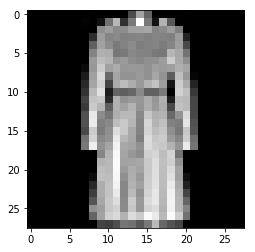

In [13]:
import matplotlib.pyplot as plt
image,label=next(iter(train_loader))#迭代，
print(image.shape,label.shape)
plt.imshow(image[0][0],cmap='gray')#0是我们展示第零个数据，matplotlib.pyplot可视化
#1是通道，28我们定义的
#每次运行对train_loader进行一次操作，每次读到的不一样（出现说明读对了）

#dataset和data_loader相结合，自己想读啥读啥

## 2.3.3模型构建
- 神经网络的构建：基于nn.Module
  __int__,forward
- 神经网络是通过“层定义+层顺序”的方式构建起来的
- 神经网络常见层
  - nn.Conv2d, nn.MaxPool2d,nn.Linear, nn.ReLU,等
- 代码演示

模型设计：搭建一个CNN，而不考虑当下各种模型的复杂结构
搭建完成，训练

In [30]:
class Net(nn.Module):#继承
    def __init__(self):#初始化
        super(Net,self).__init__()#层定义
        #Sequential惯序模型,按顺序
        self.conv=nn.Sequential(
           nn.Conv2d(1,32,5),#二维卷积  
           nn.ReLU(),#激活函数
           nn.MaxPool2d(2,stride=2),#池化？
           nn.Dropout(0.3),# 
           nn.Conv2d(32,64,5),
           nn.ReLU(),
           nn.MaxPool2d(2,stride=2),
           nn.Dropout(0,3)
        )
        self.fc=nn.Sequential(
            nn.Linear(64*4*4,512),
            nn.ReLU(),
            nn.Linear(512,10)#10是关键。输出类的个数
        )
    def forward(self,x):#前馈
        x=self.conv(x)
        x=x.view(-1,64*4*4)#拉平便于全连接层
        x=self.fc(x)#把全连接层塞进来
        #x=nn.functional.normalize(x)
        return x
model=Net()
#model=model.cuda()

?nn.Conv2d来查看  哈哈哈这个好好用

In [32]:
?nn.Conv2d

## 2.3.4损失函数
- torch.nn提供了多种预定义的损失函数
- 可以自己定义损失函数（二期）
- 根据实际需求选用对应的损失函数
- 损失函数常用操作
  - backward()

## 设定损失函数
  使用torch.nn模块自带的CrossEntropy损失
  PyTorch会自动把整数型的label转化为one-hot型（不懂），用于计算ce loss
  确保label是从0开始的，同时模型不加softmax层（使用logits计算）需要通盘考虑？？？

In [33]:
criterion=nn.CrossEntropyLoss()
#criterion=nn.CrossEntropyLoss(weight=[1,1,1,2,1,1,1,1,1,1])#就是权重越大训练越好

In [37]:
?nn.CrossEntropyLoss
#方便看策略

## 2.3.5优化器
- torch.optim提供了多种预定义的优化器
- 自己定义优化器
- 根据实际需求选择对应的损失函数
- 优化器常用操作：
 - step(),zero_grad(),load_state_dict(),
- 代码演示

定义优化器
这里使用的Adam优化器

In [38]:
optimizer=optimizer.Adam(model.parameters(),lr=0.001)

训练和测试（验证）
各自封装成函数
关注两者的主要区别
- 模型需要初始化优化器
- 是否需要loss 传回到网格
- 是否需要每一步更新optimizer

In [40]:
def train(epoch):
    model.train()
    train.loss=0#loss初始化成0
    for data,label in train_loader:#循环
        #data,label=data.cuda(),laab.cuda()#如果数据放到gpu模型也要放上去
        optimizer.zero_grad()#自动求导是会累加，这里初始化成零，放在loss.backword之前
        output=model(data)#前向传播
        loss=criterion(output,label)#损失函数
        loss.backward()#反向传播会去（理论看一看）
        optimizer.step()#优化器更新权重
        train_loss+=loss.item()*data.size(0)
    train_loss=train_loss/len(train_loader.dataset)#除以长度
    print('Epoch:{}\tTraining Loss:{:.6f}'.format(epoch,train_loss))#

In [ ]:
#封装成函数测试和验证是不一样的，模式不一样
def val(epoch):
    model.eval()
    val_loss()=0
    gt_labels=[]
    pred_labels=[]
    with torch.no_grad():#不做梯度计算
        for data,label in test_loader:
             #data,label=data.cuda(),laab.cuda()#如果数据放到gpu模型也要放上去
                outup=model(data)
                preds=torch.argmax(output,1)
                gt_labels.append(preds.cpu().data.numpy())#不太一样
                pred_labels.append(preds.cpu().data.numpy())
                loss=criterion(output,label)#损失不回传
                val_loss+=loss.item*data.size(0)
            val_loss=val_loss/len(test_loader.dataset)
            gt_labels,pre_labels=np.concatenate(gt_labels),np.concatenate(pred_labels)
            acc=np.sum(gt_labels==pred_lanles)/len(pred_labels)#准确率
            print('Epoch:{}\tValidatation Loss:{:.6f},Accuracy:{:6f}'.format(epoch,val_loss,acc))

## 2.3.6训练与评估
- 模型状态设置
 - model.train(),model.evel()
- 训练流程：读取、转换、梯度清零、输入、计算损失、反向传播、参数更新
- 验证流程：读取、转换、输入、计算损失、计算指标
- 代码演示